In [1]:
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                                 cartopy_ylim, latlon_coords)
import shapely.geometry as sgeom
# from matplotlib.cm import get_cmap
# import sys
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pathlib as pl

In [1]:
!jupyter nbconvert --to script update_geoem_DEM.ipynb

[NbConvertApp] Converting notebook update_geoem_DEM.ipynb to script
[NbConvertApp] Writing 2306 bytes to update_geoem_DEM.py


In [2]:
mask=xr.open_dataset("./ASOdata/geo_em_with_EastMask.nc")

In [3]:
dem = xr.open_dataset("./ASOdata/ASO_DEM_3m-to500m_regrid_to_wrfin0.nc")
dem = dem.drop("band")

In [4]:
geofile = xr.open_dataset("geog/geo_em_updatedDEM.d01.nc")

In [5]:
geofile["EAST_MASK"] = mask["EAST_MASK"]

## Plot the resampled (3m -- 500m) and re-gridded (bilinear, to the LSM grid) ASO dem 

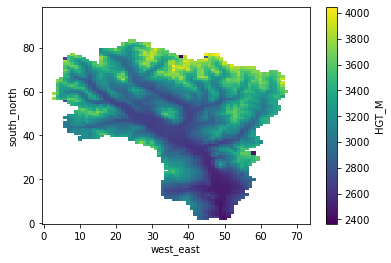

In [13]:
dem.HGT_M.where(dem.HGT_M>2300).plot()

## Plot the WPS Geogrid 500 M DEM (but the parent DEM is lower res... only 1km)

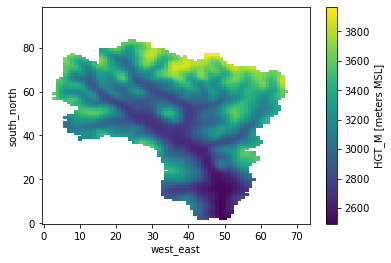

In [7]:
geofile.where(geofile.EAST_MASK==1).HGT_M.plot()

In [ ]:
## PLOT THEM TOGETHER 
plt.subplots()

### Update the grid DEM

In [13]:
patched_DEM = np.where(geofile.EAST_MASK==1, dem.HGT_M, geofile.HGT_M)

In [14]:
# for some reason the ASO DEM has some low values...
# patched_DEM = np.where(patched_DEM < 3000, geofile.HGT_M, patched_DEM)
patched_DEM = np.where(patched_DEM < 2500, geofile.HGT_M, patched_DEM)

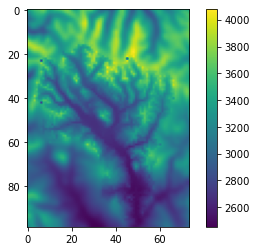

In [15]:
plt.imshow(patched_DEM[0,::-1,:])
plt.colorbar()

In [16]:
dem.HGT_M.min().values

array(0.)

In [17]:
geofile.HGT_M.min().values

array(2452.29174805)

In [18]:
patched_DEM.min()

2452.291748046875

In [22]:
geohgt = geofile.HGT_M.isel(Time=0)

### Make the difference GRID

In [23]:
hgt_diff = np.where(geofile.EAST_MASK==1, dem.HGT_M.isel(band=0) - geohgt , 0)
hgt_diff = np.where(np.abs(hgt_diff) > 200, 0, hgt_diff)

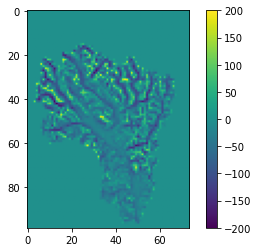

In [24]:
plt.imshow(hgt_diff[0,::-1,:], vmin=-200,vmax=200)
plt.colorbar()

### Add these to the file

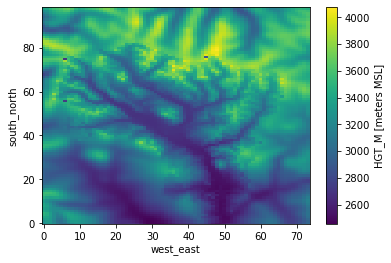

In [25]:
geofile.HGT_M.values = patched_DEM
geofile["DEMDIFF"] = geofile.HGT_M
geofile["DEMDIFF"].values = hgt_diff


geofile.HGT_M.plot()

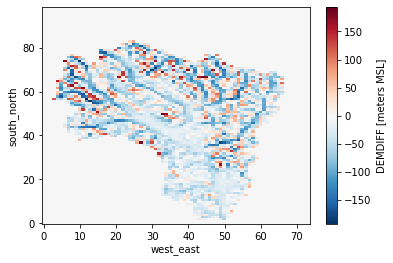

In [26]:
geofile["DEMDIFF"].plot()

In [27]:
geofile.to_netcdf("./geog/geo_em_updatedDEMc.d01.nc")